In [2]:
%matplotlib inline
import os
import imp

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import IPython.display as display


import rtmtools.clirad.sw.wrangle as swwrangle
import rtmtools.lblrtm.visualisation as viz
import rtmtools.clirad.sw.analyse as cliradanalyse

imp.reload(swwrangle)
imp.reload(viz)
imp.reload(cliradanalyse)


<module 'rtmtools.clirad.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/clirad/sw/analyse.py'>

In [3]:
matplotlib.rcParams.update({'font.size': 16,
                            'xtick.direction': 'out',
                            'ytick.direction': 'out'})

In [4]:
dir_run = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_gpts'

In [5]:
os.listdir(dir_run)

['cldreff.F',
 'co2_tran4.F',
 'h2o_tran3.F',
 'th2o.dat',
 'mainlw.F',
 'mls75_pro.F',
 'o3_tran3.F',
 'trank.dat',
 'Cloud_property_of_Chou.dat',
 'OUTPUT_CLIRAD.dat',
 'tt-output-now.dat',
 'clirad_mainlw.exe',
 'OUTPUT_CLIRAD_gpts.dat',
 'clirad_lw.exe']

In [6]:
def path_clirad_output():
    filename = 'OUTPUT_CLIRAD_gpts.dat'
    return os.path.join(dir_run, filename)

def filepath_trank():
    filename = 'trank.dat'
    return os.path.join(dir_run, filename)


def load_trank_data(filepath='trank.dat'):
    df = pd.read_csv(filepath, sep=r'\s+')
    return df


def organise_th2o():
    df = pd.read_csv(os.path.join(dir_run, 'th2o.dat'), sep=r'\s+')
    df = df.drop('i', axis=1)
    df = df.set_index(['k1', 'k2', 'ibn', 'ik'])
    df = df.unstack(['ibn', 'ik'])
    return df





def export_to_excel():
    with pd.ExcelWriter('mls_H2O_gpts.xlsx') as writer:
        
        df_coolingrate = ds['cooling_rate']\
                             .to_dataframe()\
                             .unstack(['ib', 'ik'])
                
        df_fluxes = ds[['flux_up', 'flux_down']]\
                        .to_dataframe()\
                        .stack().unstack([0, 1, 3])
        
        df_h2o = organise_th2o()
        
        df_coolingrate.to_excel(writer, sheet_name='cooling_rate')
        df_fluxes.to_excel(writer, sheet_name='fluxes')
        df_h2o.to_excel(writer, sheet_name='th2o')

In [7]:
def plot_pressure_VS_dTdt_linearlog(ds, whichrate='heating_rate', ib=7):
    
    Nik = 6
    
    srss = [ds[whichrate].sel(ib=ib, ik=ik).to_pandas() 
            for ik in range(1, Nik + 1)]
    names = ['(ib, ik) = ({}, {})'.format(ib, ik) 
             for ik in range(1, Nik + 1)]
        
    #colours, linestyles = zip(*unique_colour_linestyle_pairs(Npairs = Nik))
    colours, linestyles = zip(*viz.matplotlib_colour_linestyle_tuples(N=Nik))
    
    ylabel, xlabel = 'pressure [mbar]', '{} [deg/day]'.format(whichrate)
    title = 'Band {}'.format(ib)
    figsize = (15, 10)
    
    fig = viz.plot_pdseries_indexVSvalues_linearlog(srss=srss,
                                                    names=names,
                                                    colours=colours,
                                                    linestyles=linestyles,
                                                    ylabel=ylabel,
                                                    xlabel=xlabel,
                                                    figsize=figsize,
                                                    title=title)
    return fig


def compare_OUTPUT_CLIRAD_and_solir_gpts(pnl, ds, ib = 6):
    '''
    This plots to compare the heating rates from OUTPUT_CLIRAD and solir_gpts
    in shorwave bands 6, 7 and 8 (the solir bands).
    INPUT:
    pnl --- Pandas Panel from loading OUTPUT_CLIRAD
    ds  --- Xray Dataset from loading solir_gpts
    ib  --- spectral band to compare (6, 7, or 8)
    '''
    Trate = 'cooling_rate'
    
    srs_output_clirad = cliradanalyse.dTdt_from_pnl_clirad(pnl_clirad, 
                                                           ib=ib,
                                                           cooling_rate=True)
    srs_solir_gpts = ds[Trate].sel(ib = ib).sum(dim = 'ik').to_pandas()
    
    srss = [srs_solir_gpts, srs_output_clirad]
    names = ['summed outside CLIRAD', 'summed inside CLIRAD']
    colours, linestyles = zip(*viz.matplotlib_colour_linestyle_tuples(N = 2))
    ylabel, xlabel = 'pressure [mbar]', '{} [deg/day]'.format(Trate)
    title = 'Band {}'.format(ib)
    
    fig = viz.plot_pdseries_indexVSvalues_linearlog(srss = srss,
                                                names = names,
                                                linestyles = linestyles,
                                                colours = colours,
                                                ylabel = ylabel, xlabel = xlabel, title = title,
                                                figsize = (15, 10))
    return fig

In [8]:
def export_to_excel():
    with pd.ExcelWriter('mls_H2O_gpts.xlsx') as writer:
        
        df_coolingrate = ds['cooling_rate']\
                             .to_dataframe()\
                             .unstack(['ib', 'ik'])
                
        df_fluxes = ds[['flux_up', 'flux_down']]\
                        .to_dataframe()\
                        .stack().unstack([0, 1, 3])
        
        df_h2o = organise_th2o()
        
        df_coolingrate.to_excel(writer, sheet_name='cooling_rate')
        df_fluxes.to_excel(writer, sheet_name='fluxes')
        df_h2o.to_excel(writer, sheet_name='th2o')

In [10]:
ds = swwrangle.load_clirad_solirgpts(fpath=path_clirad_output(),
                                     signed_fluxes=True,
                                     cooling_rate=True)

In [11]:
pnl_clirad = swwrangle.\
OUTPUT_CLIRAD_to_PandasPanel(readfrom=os.path.join(dir_run, 
                                                   'OUTPUT_CLIRAD.dat'),
                             signed_fluxes=True,
                             cooling_rate=True)

In [32]:
export_to_excel()

# Plots

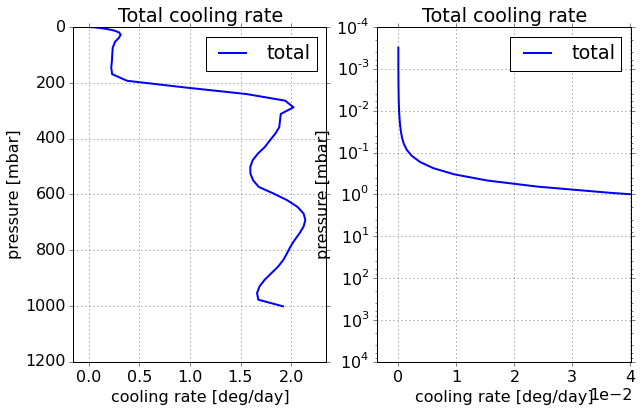

In [12]:
srs = ds['cooling_rate'].sum(dim=['ib', 'ik']).to_pandas()

names = ['total']
colours = ['b']
linestyles = ['-']
ylabel = 'pressure [mbar]'
xlabel = 'cooling rate [deg/day]'
figsize = (10, 6)
title = 'Total cooling rate'

fig = viz.plot_pdseries_indexVSvalues_linearlog(srss=[srs],
                                                names=names,
                                                colours=colours,
                                                linestyles=linestyles,
                                                ylabel=ylabel,
                                                xlabel=xlabel,
                                                figsize=figsize,
                                                title=title)

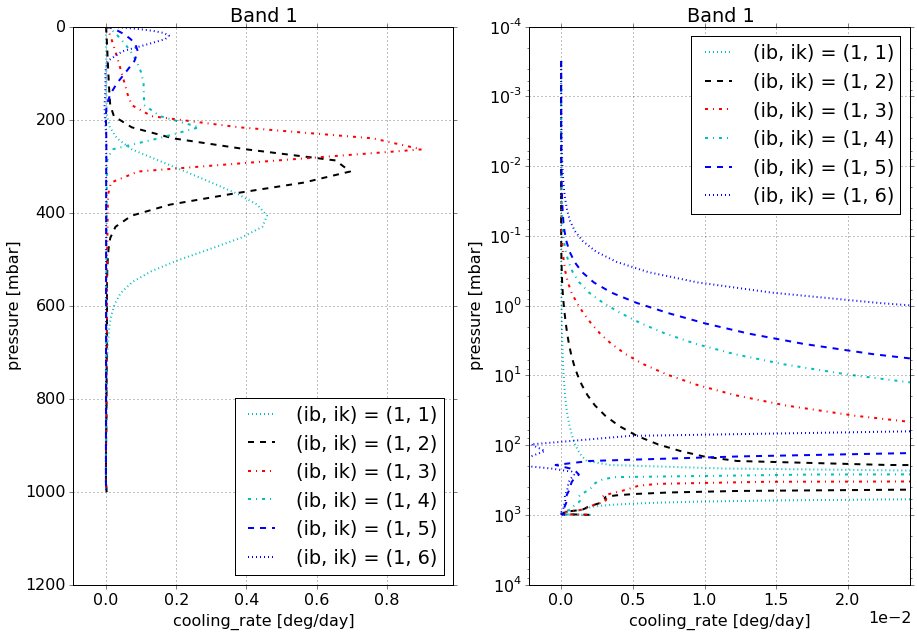

In [13]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=1)

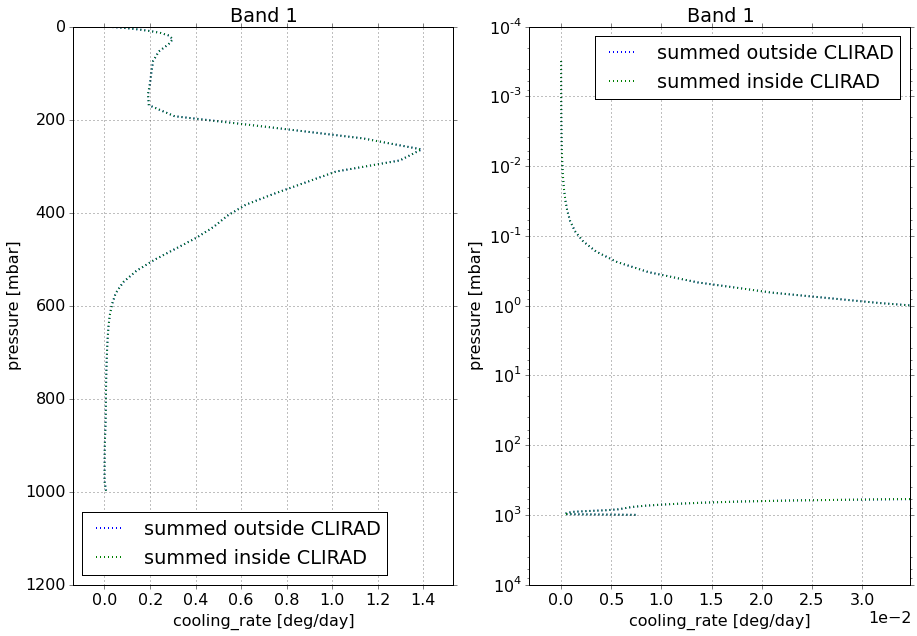

In [14]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=1)

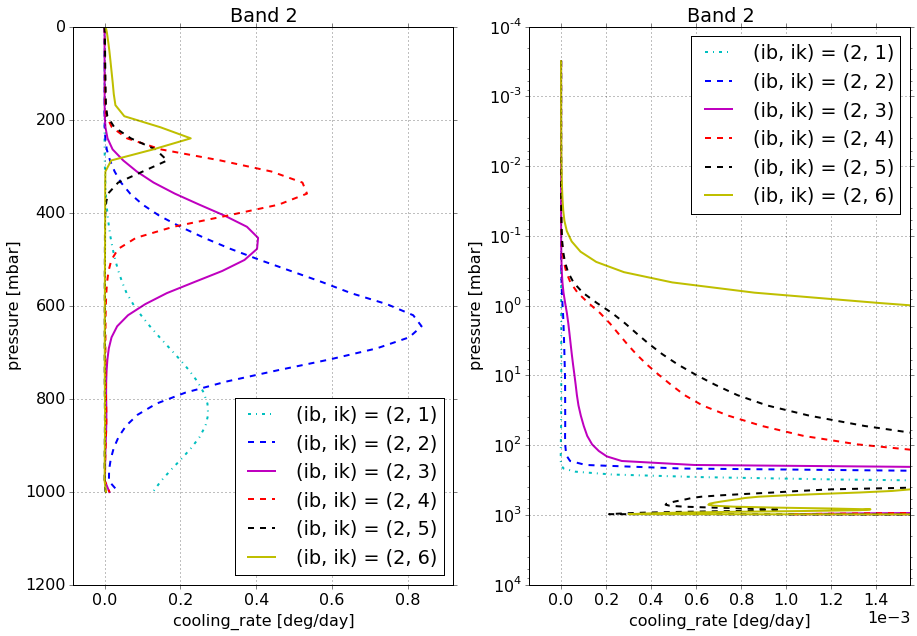

In [15]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=2)

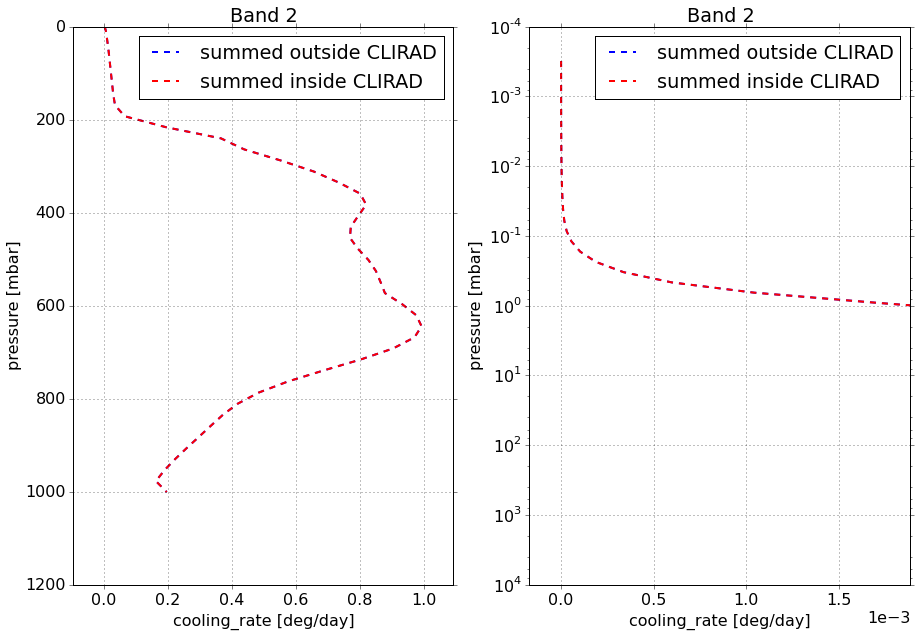

In [16]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=2)

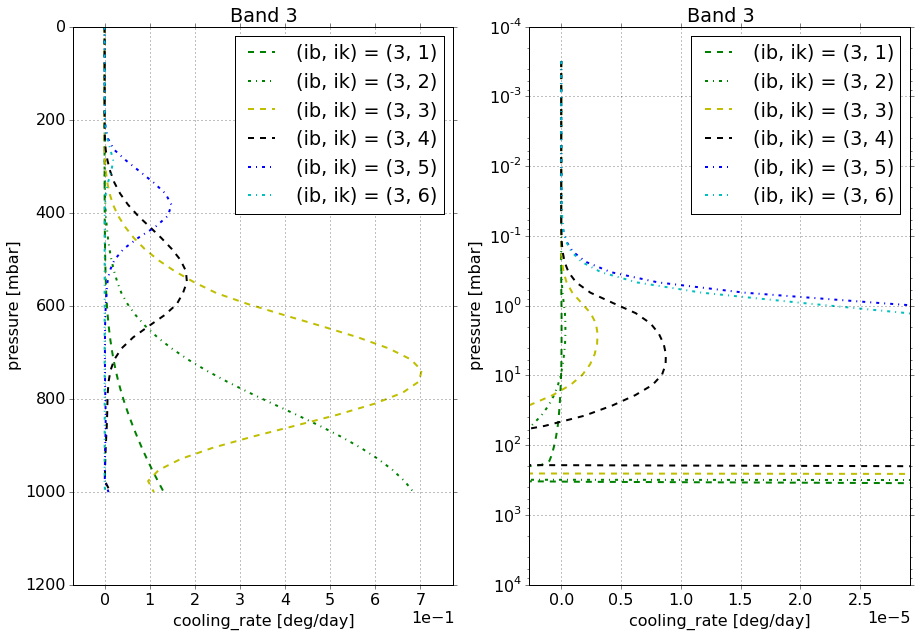

In [17]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=3)

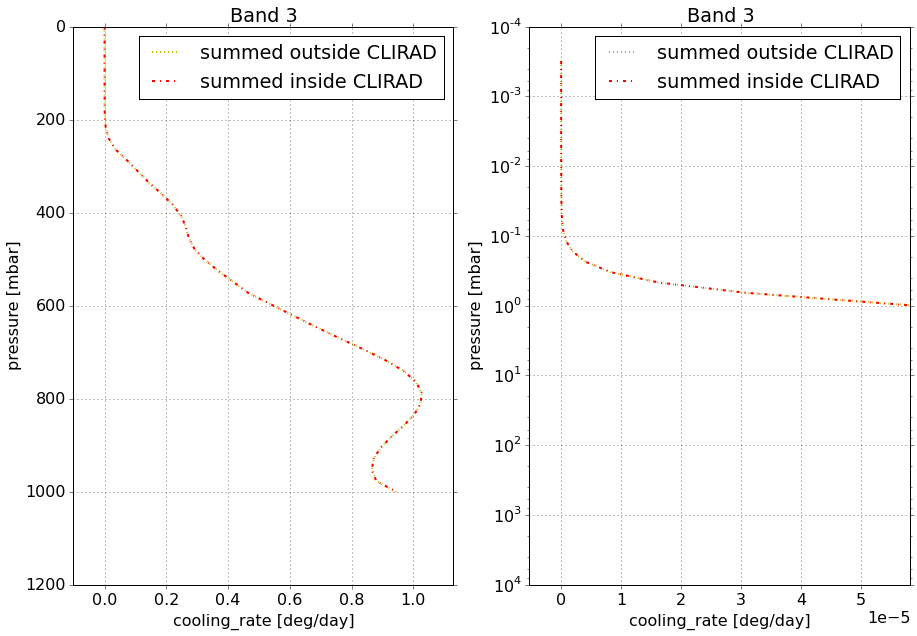

In [18]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=3)

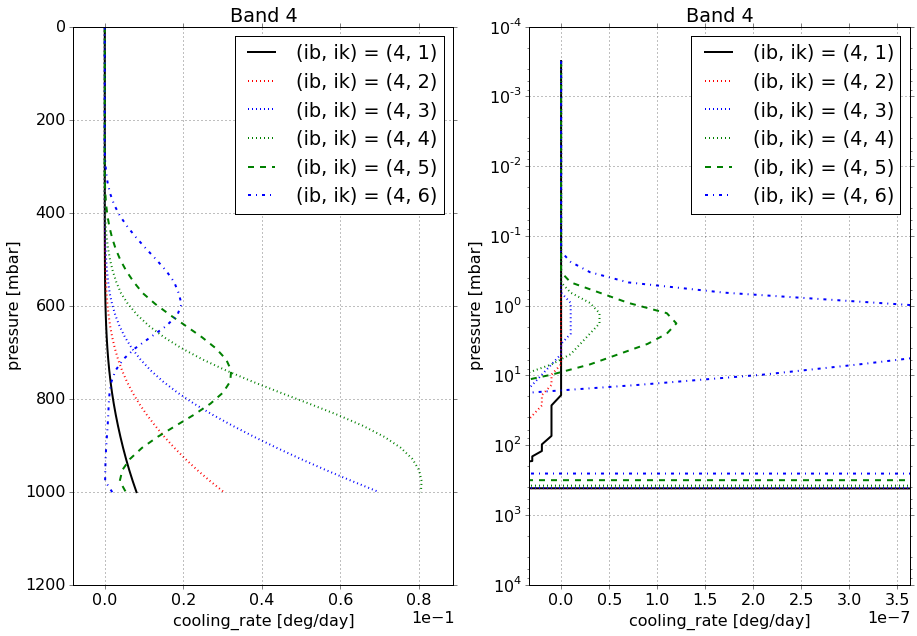

In [19]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=4)

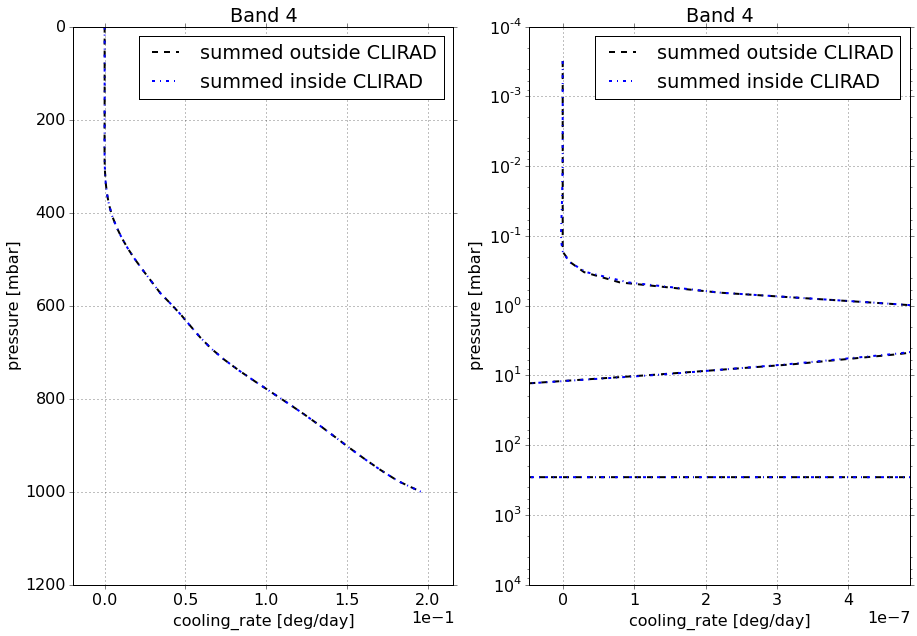

In [20]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=4)

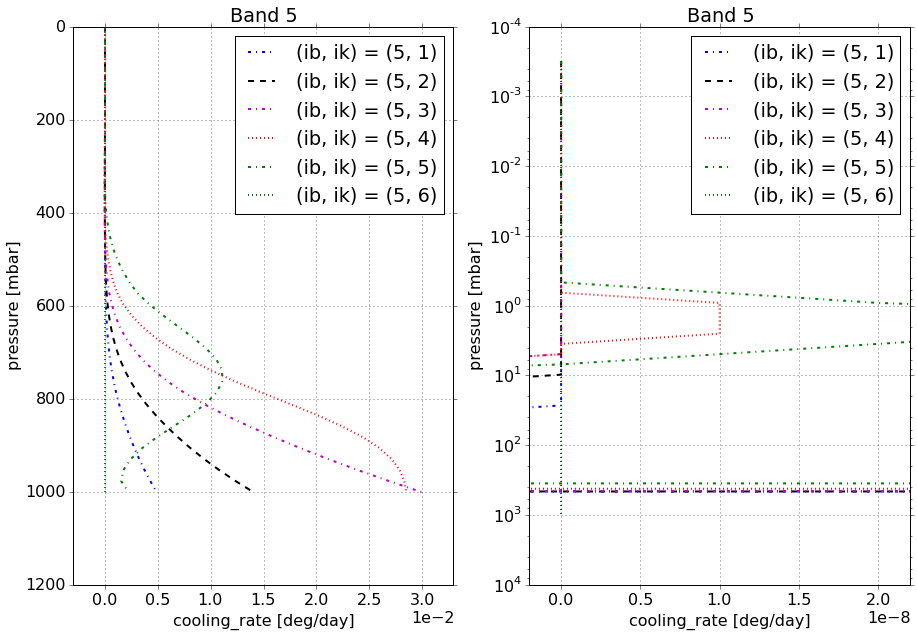

In [21]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=5)

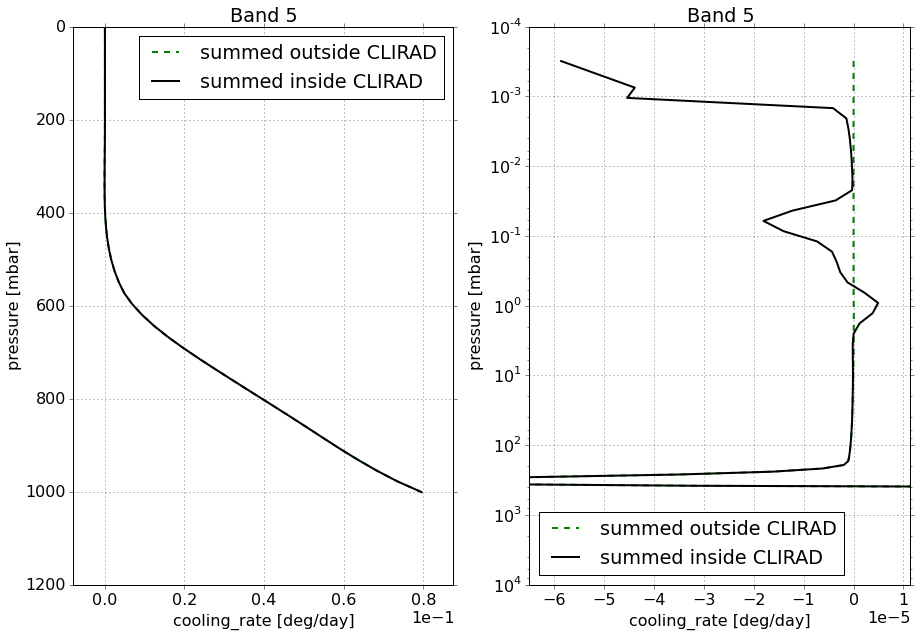

In [22]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=5)

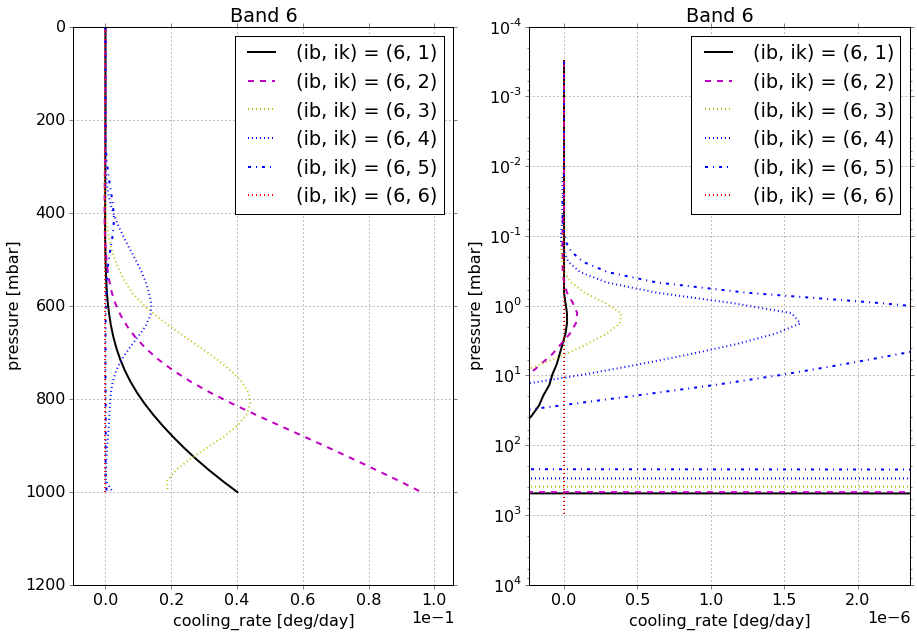

In [23]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=6)

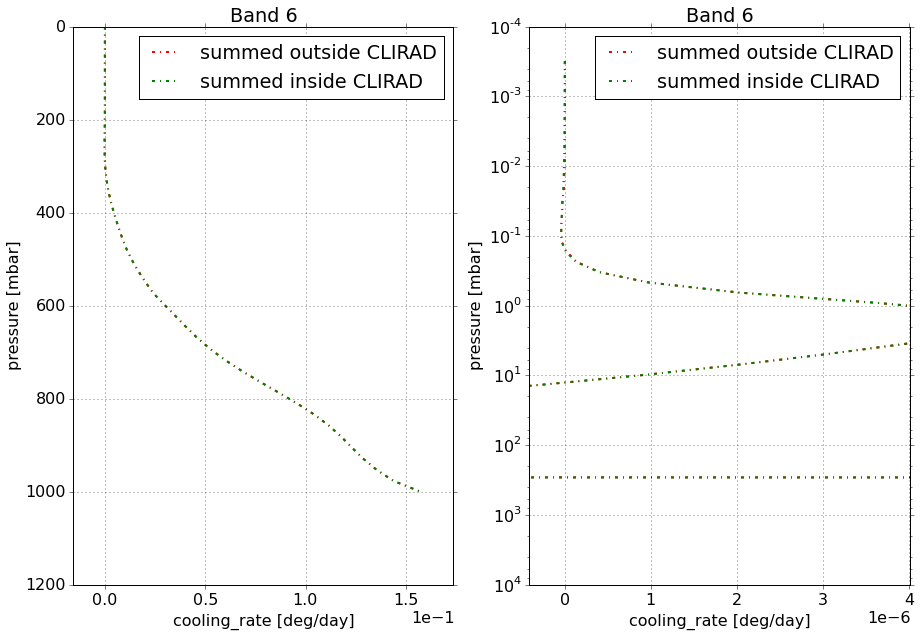

In [32]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=6)

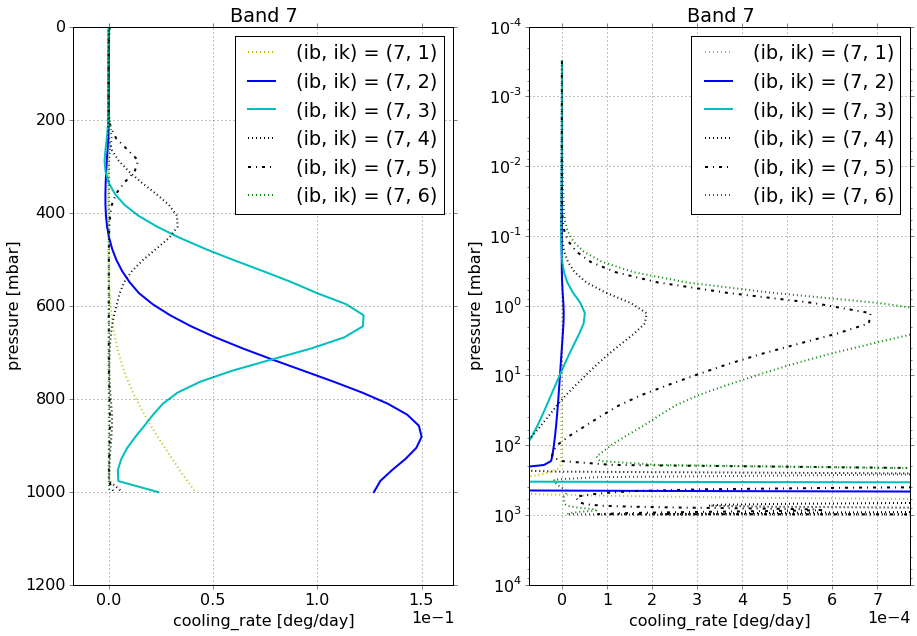

In [25]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=7)

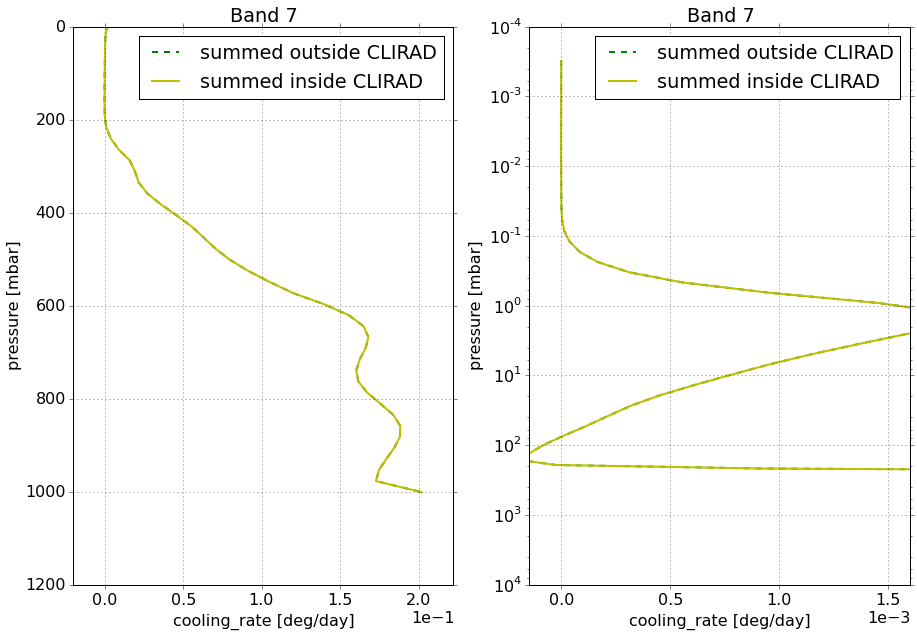

In [26]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=7)

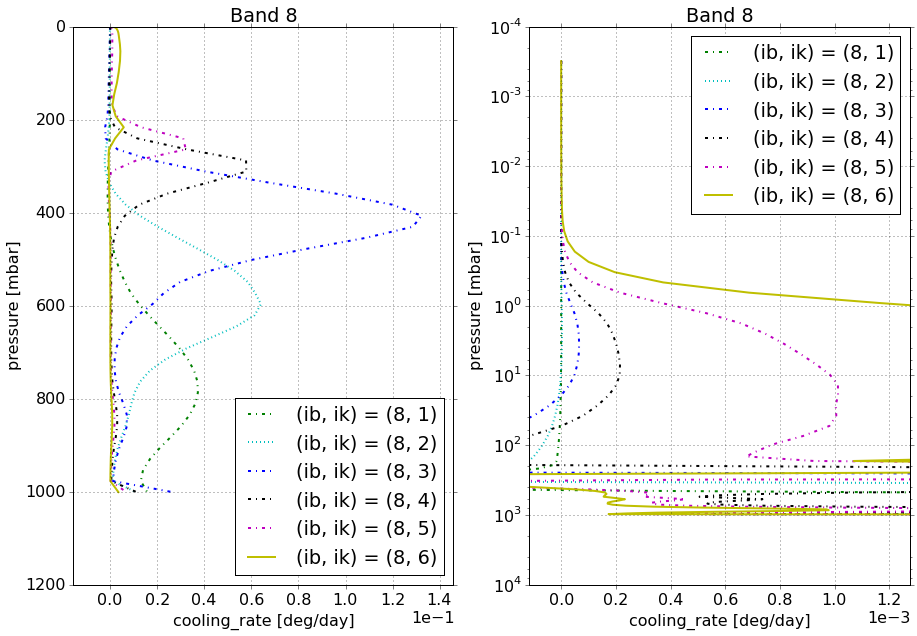

In [27]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=8)

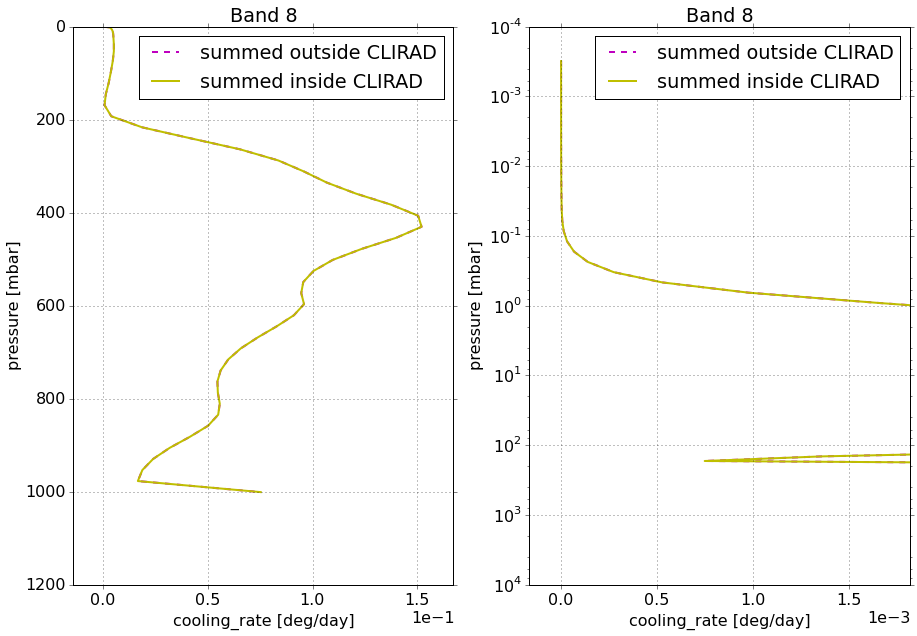

In [34]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=8)

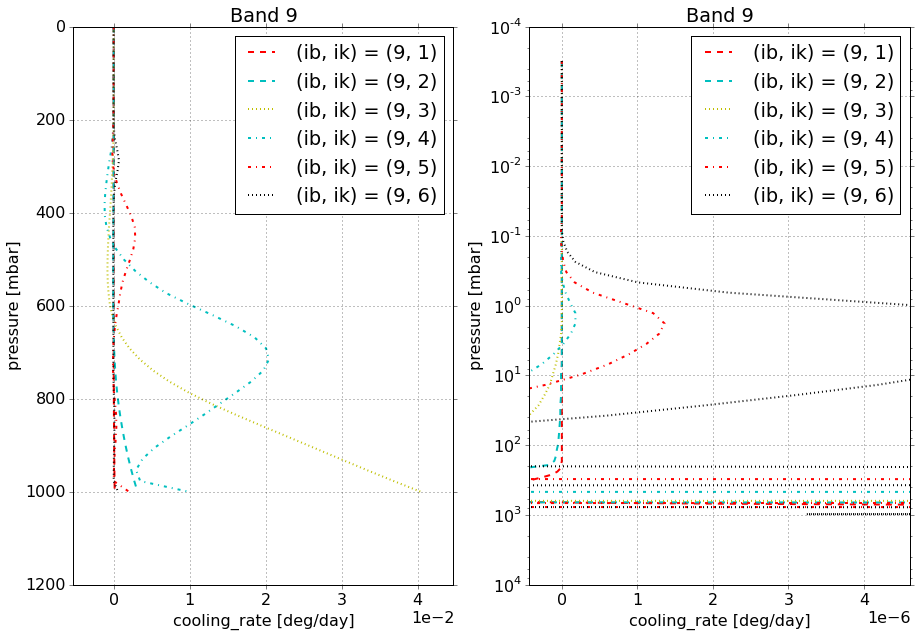

In [29]:
fig = plot_pressure_VS_dTdt_linearlog(ds, whichrate='cooling_rate', ib=9)

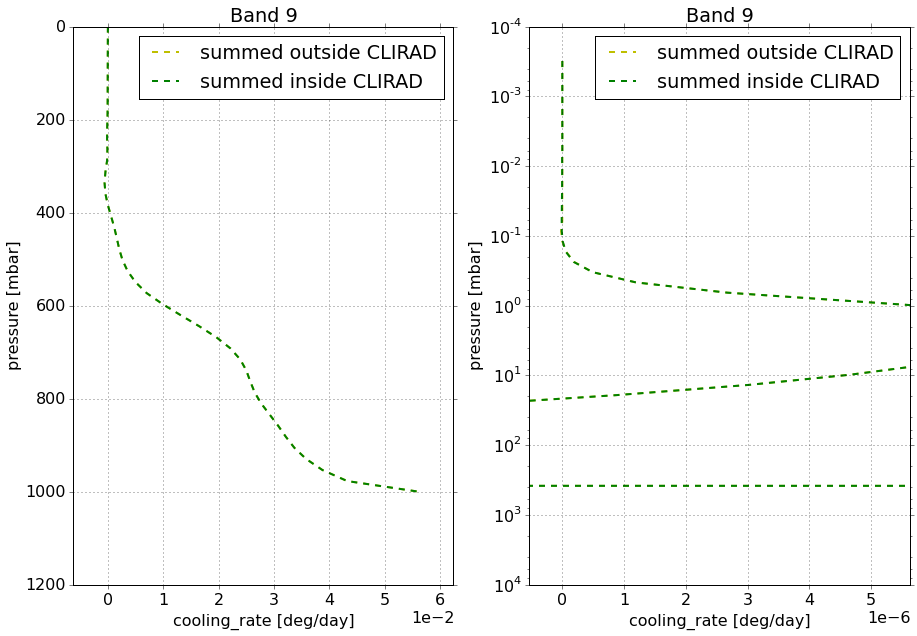

In [30]:
fig = compare_OUTPUT_CLIRAD_and_solir_gpts(pnl_clirad, ds, ib=9)

In [31]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')